In [1]:
# 1. Environment Setup
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import shape
import pyproj
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm import tqdm
import multiprocessing



In [2]:
### ONLY ON NOTEBOOK ###
import os   
os.chdir("/Users/upar/Library/CloudStorage/OneDrive-Universidaddelosandes/capacidad-estatal")

: 

: 

In [44]:
# 2. Data Import
# Load the spatial datasets
pop_hex = gpd.read_file("datos/population/colombia/kontur_population_CO_20231101.gpkg")
col_dpto = gpd.read_file("datos/spatial/MGN2023_DPTO_POLITICO/MGN_ADM_DPTO_POLITICO.shp")
roads_colombia = gpd.read_file("datos/spatial/colombia_roads.gpkg")



In [13]:
col_dpto.to_crs("epsg:3116").crs.is_projected

True

In [12]:
col_dpto.crs.is_projected

False

In [ ]:
# 3. Coordinate Transformation
# Ensure all datasets use the same CRS (coordinate reference system)
# Ensure all datasets use the EPSG:3116 CRS

if pop_hex.crs != "epsg:3116":
    pop_hex = pop_hex.to_crs("epsg:3116")

if roads_colombia.crs != "epsg:3116":
    roads_colombia = roads_colombia.to_crs("epsg:3116")

if col_dpto.crs != "epsg:3116":
    col_dpto = col_dpto.to_crs("epsg:3116")

In [14]:
col_dpto['area_km2_3116'] = col_dpto.to_crs("epsg:3116").geometry.area/1e6

In [15]:
col_dpto['area_km2_102033'] = col_dpto.to_crs("esri:102033").geometry.area/1e6

In [32]:
# Read the "/Users/upar/Downloads/world-administrative-boundaries.geojson" file
world_administrative_boundaries = gpd.read_file("/Users/upar/Downloads/world-administrative-boundaries.geojson")
south_america = world_administrative_boundaries[world_administrative_boundaries['region']=="South America"]

Fontconfig warning: ignoring UTF-8: not a valid region tag
Matplotlib is building the font cache; this may take a moment.


<Axes: >

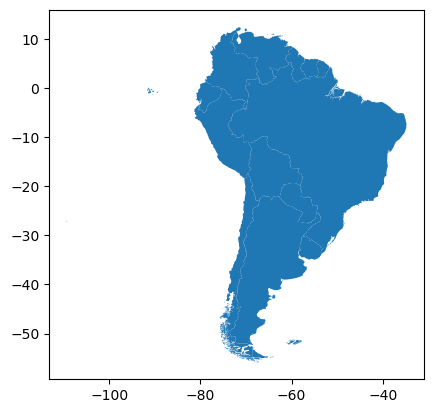

In [34]:
# plot south_america 
south_america.plot()

In [40]:
south_america.columns

Index(['geo_point_2d', 'iso3', 'status', 'color_code', 'name', 'continent',
       'region', 'iso_3166_1_alpha_2_codes', 'french_short', 'geometry'],
      dtype='object')

In [43]:
south_america[['iso3']].reset_index()

# arrange by iso3 alphabetically

south_america[['iso3']].reset_index().sort_values('iso3')

,index,iso3
9,191,ARG
8,169,BOL
13,254,BRA
10,194,CHL
5,127,COL
12,236,ECU
11,215,FLK
0,26,GUF
6,132,GUY
2,57,PER


In [ ]:
# 4. Spatial Intersections
# Helper function for spatial intersection using parallel processing
def parallel_intersection(df1, df2):
    # Split the data for parallel processing
    num_cores = multiprocessing.cpu_count()
    df_split = np.array_split(df1, num_cores)
    
    with multiprocessing.Pool(num_cores) as pool:
        # Use tqdm to track progress
        result = list(tqdm(pool.imap(lambda x: gpd.overlay(x, df2, how='intersection'), df_split), total=len(df_split)))
    
    # Concatenate the results back together
    return pd.concat(result, ignore_index=True)

# Roads with Departments
try:
    # If the file already exists, load it
    roads_dpto_intersect = gpd.read_parquet("datos/spatial/roads_dpto_intersect.rds")
except FileNotFoundError:
    # Perform the spatial intersection
    roads_dpto_intersect = parallel_intersection(roads_colombia, col_dpto)
    # Save to a file
    roads_dpto_intersect.to_parquet("datos/spatial/roads_dpto_intersect.rds", index=False)

# Population with Departments
try:
    # If the file already exists, load it
    pop_dpto_intersect = gpd.read_parquet("datos/spatial/pop_dpto_intersect.rds")
except FileNotFoundError:
    # Perform the spatial intersection
    pop_dpto_intersect = parallel_intersection(pop_hex, col_dpto)
    # Save to a file
    pop_dpto_intersect.to_parquet("datos/spatial/pop_dpto_intersect.rds", index=False)



In [ ]:
# 5. Road Density Calculation
# Road Length Calculation
roads_dpto_intersect['length_km'] = roads_dpto_intersect.geometry.length / 1000  # Convert to kilometers

# Department Area Calculation
col_dpto['area_km2'] = col_dpto.geometry.area / 1e6  # Convert to square kilometers

# Aggregate Road Lengths
road_length_by_dpto = roads_dpto_intersect.groupby('dpto_ccdgo')['length_km'].sum().reset_index()
road_length_by_dpto.columns = ['dpto_ccdgo', 'total_road_length_km']

# Compute Road Density
col_dpto = col_dpto.merge(road_length_by_dpto, on='dpto_ccdgo', how='left')
col_dpto['road_density'] = col_dpto['total_road_length_km'] / col_dpto['area_km2']



In [ ]:
# 6. Population Density Calculation
# Aggregate Population by Department
pop_by_dpto = pop_dpto_intersect.groupby('dpto_ccdgo')['population'].sum().reset_index()
pop_by_dpto.columns = ['dpto_ccdgo', 'total_population']

# Compute Population Density
col_dpto = col_dpto.merge(pop_by_dpto, on='dpto_ccdgo', how='left')
col_dpto['pop_density'] = col_dpto['total_population'] / col_dpto['area_km2']



In [ ]:
# 7. Data Export
# Select and reorder the columns for final output
final_df = col_dpto[['dpto_ccdgo', 'area_km2', 'total_road_length_km', 'road_density', 'pop_density']].copy()

# Export the final DataFrame to a Parquet file
final_df.to_parquet('colombia-departments_road_pop.parquet', index=False)


In [45]:
# Read "/Users/upar/Downloads/gadm41_ARG.gpkg"
gpkg = gpd.read_file("/Users/upar/Downloads/gadm41_ARG.gpkg")

/opt/anaconda3/envs/sc/lib/python3.9/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'gadm41_ARG.gpkg': 'ADM_ADM_0' (default), 'ADM_ADM_1', 'ADM_ADM_2'. Specify layer parameter to avoid this warning.
  result = read_func(


In [3]:
# Read "/Users/upar/Downloads/gadm41_GUY.gpkg"
gpkg = gpd.read_file("/Users/upar/Library/CloudStorage/OneDrive-Universidaddelosandes/capacidad-estatal/codigo/01_build/03_output/south_america_admin_divisions.gpkg")
# gpkg[gpkg['GID_0'] == 'URY'].plot()
gpkg['GID_0'].value_counts()

GID_0
COL    33
BRA    27
PER    26
VEN    25
ARG    24
ECU    24
URY    19
PRY    18
CHL    16
GUY    10
SUR    10
BOL     9
GUF     2
Name: count, dtype: int64

In [53]:
# list layers in the file "/Users/upar/Downloads/gadm41_GUY.gpkg"
import pyogrio
dir(pyogrio)
#fiona.listlayers("/Users/upar/Downloads/gadm41_GUY.gpkg")

['__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__gdal_geos_version__',
 '__gdal_version__',
 '__gdal_version_string__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_compat',
 '_env',
 '_err',
 '_geometry',
 '_io',
 '_ogr',
 '_version',
 '_vsi',
 'core',
 'detect_write_driver',
 'errors',
 'geopandas',
 'get_gdal_config_option',
 'get_gdal_data_path',
 'list_drivers',
 'list_layers',
 'open_arrow',
 'raw',
 'read_arrow',
 'read_bounds',
 'read_dataframe',
 'read_info',
 'set_gdal_config_options',
 'shapely',
 'util',
 'vsi_listtree',
 'vsi_rmtree',
 'vsi_unlink',
 'write_arrow',
 'write_dataframe']

In [54]:
pyogrio.list_layers("/Users/upar/Downloads/gadm41_GUY.gpkg")

array([['ADM_ADM_0', 'MultiPolygon'],
       ['ADM_ADM_1', 'MultiPolygon'],
       ['ADM_ADM_2', 'MultiPolygon']], dtype=object)